In [1]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

In [2]:
chart48 = pd.read_csv("../Code/output/chart48Item17.csv")

In [3]:
patients = pd.read_csv("../Code/output/patientsinfo.csv")

In [4]:
chart48.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00


In [5]:
chart48.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17949246 entries, 0 to 17949245
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 684.7+ MB


# Data cleaning

In [8]:
def chart_cleaning(df):
    # GLU
    df = df.drop(df[(df.ITEMID=='GLU') & (df.VALUE>5000)].index)
    # DBP
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE<0)].index)
    # FIO -- ignore
    # df = df.drop(df[(df.ITEMID=='FIO') & (df.VALUE>100)].index)
    # HEIGHT
    df = df.drop(df[(df.ITEMID=='HEIGHT') & (df.VALUE>300)].index)
    # HR
    df = df.drop(df[(df.ITEMID=='HR') & (df.VALUE>10000)].index)
    # MBP
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE<0)].index)
    # OS
    df = df.drop(df[(df.ITEMID=='OS') & (df.VALUE>10000)].index)
    # PH
    df = df.drop(df[(df.ITEMID=='PH') & (df.VALUE>10)].index) 
    # RESPR
    df = df.drop(df[(df.ITEMID=='RESPR') & (df.VALUE>1000)].index)
    # SBP
    df = df.drop(df[(df.ITEMID=='SBP') & (df.VALUE>1000)].index)
    # TEMP
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE>50)].index) 
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE<20)].index)
    # weight
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE>1000)].index) 
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE<10)].index)

    return df

In [9]:
chart48 = chart_cleaning(chart48)

In [10]:
chart48.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17946388 entries, 0 to 17949245
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 821.5+ MB


# Data preprocessing

In [11]:
chart48[['TIME']] = chart48['CHARTTIME'].apply(lambda x: x[:10] +' '+ x[11:13])

In [12]:
chart48.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,TIME
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00,2134-05-12 12
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29,2134-05-12 12
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00,2134-05-12 13
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00,2134-05-12 13
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00,2134-05-12 13


In [13]:
chart48_hourly = chart48[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'TIME']].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'TIME'], as_index=False).mean()

In [14]:
chart48_hourly.head()

,SUBJECT_ID,HADM_ID,ITEMID,TIME,VALUE
0,3,145834,DBP,2101-10-20 18,24.000000
1,3,145834,DBP,2101-10-20 19,36.200000
2,3,145834,DBP,2101-10-20 20,47.125000
3,3,145834,DBP,2101-10-20 21,44.375000
4,3,145834,DBP,2101-10-20 22,67.666667


In [15]:
chart48_hourly.info() ## 8039549 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13195825 entries, 0 to 13195824
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   TIME        object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 604.1+ MB


In [16]:
items17 = chart48['ITEMID'].unique()

In [17]:
chart48_hourly_pivot = chart48_hourly.pivot(index = ['HADM_ID', 'TIME'],columns='ITEMID', values = 'VALUE')

In [18]:
chart48_hourly_pivot.tail()

ITEMID                 CRR   DBP   FIO  GLU  GMR   GO  GT  GVR  HEIGHT    HR  \
HADM_ID TIME                                                                   
199999  2136-04-08 12  NaN  54.0  50.0  NaN  6.0  4.0 NaN  5.0     NaN  72.0   
        2136-04-08 13  NaN  93.0   NaN  NaN  NaN  NaN NaN  NaN     NaN  76.0   
        2136-04-08 14  NaN  55.0   NaN  NaN  NaN  NaN NaN  NaN     NaN  73.0   
        2136-04-08 15  NaN  50.0  50.0  NaN  NaN  NaN NaN  NaN     NaN  75.0   
        2136-04-08 16  NaN  64.0   NaN  NaN  6.0  4.0 NaN  5.0     NaN  76.0   

ITEMID                  MBP    OS  PH  RESPR    SBP  TEMP  WEIGHT  
HADM_ID TIME                                                       
199999  2136-04-08 12  77.0  95.0 NaN   23.0  148.0   NaN     NaN  
        2136-04-08 13  96.0  94.0 NaN   29.0  129.0   NaN     NaN  
        2136-04-08 14  80.0  95.0 NaN   19.0  151.0   NaN     NaN  
        2136-04-08 15  71.0  92.0 NaN   25.0  131.0   NaN     NaN  
        2136-04-08 16  80.0  93.0 NaN   21.0  136.0  36.5     NaN

In [19]:
chart48_hourly_pivot2 = chart48_hourly_pivot.reset_index()

In [20]:
chart48_hourly_pivot2.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,HEIGHT,HR,MBP,OS,PH,RESPR,SBP,TEMP,WEIGHT
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,NaN,NaN,NaN,14.0,NaN,NaN,98.01
1,100001,2117-09-11 13,NaN,100.0,NaN,NaN,6.0,4.0,NaN,5.0,NaN,118.0,122.0,NaN,NaN,22.0,192.0,36.666667,NaN
2,100001,2117-09-11 14,NaN,85.0,NaN,261.0,NaN,NaN,NaN,NaN,NaN,118.0,103.0,NaN,NaN,15.0,165.0,NaN,NaN
3,100001,2117-09-11 15,NaN,64.0,NaN,179.5,NaN,NaN,NaN,NaN,NaN,110.0,76.0,NaN,NaN,15.0,119.0,NaN,NaN
4,100001,2117-09-11 16,NaN,84.0,NaN,170.0,6.0,4.0,NaN,5.0,NaN,104.0,105.0,100.0,NaN,16.0,169.0,36.611111,NaN


In [21]:
chart48_hourly_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723607 entries, 0 to 1723606
Data columns (total 19 columns):
 #   Column   Dtype  
---  ------   -----  
 0   HADM_ID  int64  
 1   TIME     object 
 2   CRR      float64
 3   DBP      float64
 4   FIO      float64
 5   GLU      float64
 6   GMR      float64
 7   GO       float64
 8   GT       float64
 9   GVR      float64
 10  HEIGHT   float64
 11  HR       float64
 12  MBP      float64
 13  OS       float64
 14  PH       float64
 15  RESPR    float64
 16  SBP      float64
 17  TEMP     float64
 18  WEIGHT   float64
dtypes: float64(17), int64(1), object(1)
memory usage: 249.9+ MB


In [22]:
chart48_norm = chart48_hourly_pivot2.copy()

In [23]:
for col in chart48_norm.columns[2:]:
    chart48_norm[[col]] = (chart48_norm[[col]] - chart48_norm[[col]].min())/(chart48_norm[[col]].max()-chart48_norm[[col]].min())

In [24]:
chart48_norm.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,HEIGHT,HR,MBP,OS,PH,RESPR,SBP,TEMP,WEIGHT
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018396,NaN,NaN,NaN,0.033466,NaN,NaN,0.095663
1,100001,2117-09-11 13,NaN,0.104058,NaN,NaN,1.0,1.0,NaN,1.0,NaN,0.017793,0.159477,NaN,NaN,0.052590,0.467153,0.739448,NaN
2,100001,2117-09-11 14,NaN,0.088450,NaN,0.150156,NaN,NaN,NaN,NaN,NaN,0.017793,0.134641,NaN,NaN,0.035857,0.401460,NaN,NaN
3,100001,2117-09-11 15,NaN,0.066597,NaN,0.118370,NaN,NaN,NaN,NaN,NaN,0.016586,0.099346,NaN,NaN,0.035857,0.289538,NaN,NaN
4,100001,2117-09-11 16,NaN,0.087409,NaN,0.114665,1.0,1.0,NaN,1.0,NaN,0.015682,0.137255,0.010314,NaN,0.038247,0.411192,0.736843,NaN


In [25]:
# fill null with -1
chart48_norm.fillna(-1, inplace=True)

In [26]:
chart48_norm.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,HEIGHT,HR,MBP,OS,PH,RESPR,SBP,TEMP,WEIGHT
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.018396,-1.000000,-1.000000,-1.0,0.033466,-1.000000,-1.000000,0.095663
1,100001,2117-09-11 13,-1.0,0.104058,-1.0,-1.000000,1.0,1.0,-1.0,1.0,-1.0,0.017793,0.159477,-1.000000,-1.0,0.052590,0.467153,0.739448,-1.000000
2,100001,2117-09-11 14,-1.0,0.088450,-1.0,0.150156,-1.0,-1.0,-1.0,-1.0,-1.0,0.017793,0.134641,-1.000000,-1.0,0.035857,0.401460,-1.000000,-1.000000
3,100001,2117-09-11 15,-1.0,0.066597,-1.0,0.118370,-1.0,-1.0,-1.0,-1.0,-1.0,0.016586,0.099346,-1.000000,-1.0,0.035857,0.289538,-1.000000,-1.000000
4,100001,2117-09-11 16,-1.0,0.087409,-1.0,0.114665,1.0,1.0,-1.0,1.0,-1.0,0.015682,0.137255,0.010314,-1.0,0.038247,0.411192,0.736843,-1.000000


In [27]:
chart48_norm[['value']] = chart48_norm.apply(lambda x: list(x['CRR':]), axis=1)

In [28]:
chart48_norm.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,HEIGHT,HR,MBP,OS,PH,RESPR,SBP,TEMP,WEIGHT,value
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.018396,-1.000000,-1.000000,-1.0,0.033466,-1.000000,-1.000000,0.095663,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,100001,2117-09-11 13,-1.0,0.104058,-1.0,-1.000000,1.0,1.0,-1.0,1.0,-1.0,0.017793,0.159477,-1.000000,-1.0,0.052590,0.467153,0.739448,-1.000000,"[-1.0, 0.1040582726326743, -1.0, -1.0, 1.0, 1...."
2,100001,2117-09-11 14,-1.0,0.088450,-1.0,0.150156,-1.0,-1.0,-1.0,-1.0,-1.0,0.017793,0.134641,-1.000000,-1.0,0.035857,0.401460,-1.000000,-1.000000,"[-1.0, 0.08844953173777315, -1.0, 0.1501560062..."
3,100001,2117-09-11 15,-1.0,0.066597,-1.0,0.118370,-1.0,-1.0,-1.0,-1.0,-1.0,0.016586,0.099346,-1.000000,-1.0,0.035857,0.289538,-1.000000,-1.000000,"[-1.0, 0.06659729448491156, -1.0, 0.1183697347..."
4,100001,2117-09-11 16,-1.0,0.087409,-1.0,0.114665,1.0,1.0,-1.0,1.0,-1.0,0.015682,0.137255,0.010314,-1.0,0.038247,0.411192,0.736843,-1.000000,"[-1.0, 0.08740894901144641, -1.0, 0.1146645865..."


In [29]:
chart48_grouped = chart48_norm[['HADM_ID', 'value']].groupby('HADM_ID').agg(lambda x: list(x))

In [33]:
chart48_grouped[['num_stamps']] = chart48_grouped['value'].apply(lambda x: len(x))

In [34]:
chart48_grouped.head()

ITEMID,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",48
100003,"[[-1.0, 0.037460978147762745, -1.0, -1.0, 1.0,...",44
100006,"[[-1.0, 0.08949011446409989, -1.0, -1.0, 1.0, ...",48
100007,"[[-1.0, 0.06659729448491156, -1.0, 0.093213728...",32
100009,"[[-1.0, -1.0, -1.0, 0.09126365054602184, -1.0,...",42


In [35]:
chart48_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45851 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       45851 non-null  object
 1   num_stamps  45851 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [36]:
# remove the admissions which has more than 30 timestamps
chart48_grouped.drop(chart48_grouped[chart48_grouped['num_stamps']>60].index, inplace=True)

In [37]:
chart48_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45839 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       45839 non-null  object
 1   num_stamps  45839 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [38]:
chart48_grouped.head()

ITEMID,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",48
100003,"[[-1.0, 0.037460978147762745, -1.0, -1.0, 1.0,...",44
100006,"[[-1.0, 0.08949011446409989, -1.0, -1.0, 1.0, ...",48
100007,"[[-1.0, 0.06659729448491156, -1.0, 0.093213728...",32
100009,"[[-1.0, -1.0, -1.0, 0.09126365054602184, -1.0,...",42


In [39]:
chart48_valueWithLabel = chart48_grouped[['value']].join(patients[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']].set_index('HADM_ID'), how='inner')


In [40]:
# split the data to train and test
chart48_shuffle = chart48_valueWithLabel.sample(frac=1)
chart48_test = chart48_shuffle.iloc[:7000, ]
chart48_valid = chart48_shuffle.iloc[7001:14000, ]
chart48_train = chart48_shuffle.iloc[14001: ,]


In [41]:
# process train dataset
train_label = chart48_train['HOSPITAL_EXPIRE_FLAG'].tolist()
train_data = chart48_train['value'].tolist()


'\npack the data which has less than 30 timestamp\ntrain_data_seqs = []\npack_list = [-1]*17\n\nfor a in train_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        train_data_seqs.append(a)\n    else:\n        train_data_seqs.append(a)\n\n'

In [42]:
# process validation dataset
valid_label = chart48_valid['HOSPITAL_EXPIRE_FLAG'].tolist()
valid_data = chart48_valid['value'].tolist()


'\n# pack the data which has less than 30 timestamp\nvalid_data_seqs = []\npack_list = [-1]*17\n\nfor a in valid_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        valid_data_seqs.append(a)\n    else:\n        valid_data_seqs.append(a)\n     \n'

In [43]:
# process test dataset
test_label = chart48_test['HOSPITAL_EXPIRE_FLAG'].tolist()
test_data = chart48_test['value'].tolist()


'\ntest_data_seqs = []\npack_list = [-1]*17\nfor a in test_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        test_data_seqs.append(a)\n    else:\n        test_data_seqs.append(a)\n     \n'

# RNN model

In [44]:
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset

from utils import train, evaluate
from plots import plot_learning_curves, plot_confusion_matrix

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
class MyVariableRNN(nn.Module):
	def __init__(self, dim_input):
		super(MyVariableRNN, self).__init__()
		# You may use the input argument 'dim_input', which is basically the number of features

		self.fc1 = nn.Linear(in_features = dim_input , out_features = 32)
		self.rnn = nn.GRU(input_size = 32, hidden_size=16, num_layers=2, batch_first=True, dropout=0.5)
		self.fc2 = nn.Linear(in_features = 16, out_features = 2)
       

	def forward(self, input_tuple):
		# HINT: Following two methods might be useful
		# 'pack_padded_sequence' and 'pad_packed_sequence' from torch.nn.utils.rnn
		seqs, lengths = input_tuple
       
		seqs = torch.tanh(self.fc1(seqs))
                            
		seqs = pack_padded_sequence(seqs, lengths=lengths, batch_first=True)
		seqs, _ = self.rnn(seqs)
        
		seqs, _ = pad_packed_sequence(seqs, batch_first=True)
		idx = (torch.LongTensor(lengths) - 1).view(-1, 1).expand(len(lengths), seqs.size(2))
		idx = idx.unsqueeze(1)
		last_output = seqs.gather(1, Variable(idx)).squeeze(1)       
     
		seqs = self.fc2(last_output)
        
		return seqs

In [46]:
class VisitSequenceWithLabelDataset(Dataset):
	def __init__(self, seqs, labels, num_features):
		"""
		Args:
			seqs (list): list of patients (list) of visits (list) of codes (int) that contains visit sequences
			labels (list): list of labels (int)
			num_features (int): number of total features available
		"""

		if len(seqs) != len(labels):
			raise ValueError("Seqs and Labels have different lengths")

		self.labels = labels
		self.seqs=[]        
		for i in seqs:
			i_matrix = np.asarray(i)
			self.seqs.append(i_matrix)
             

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, index):
		# returns will be wrapped as List of Tensor(s) by DataLoader
		return self.seqs[index], self.labels[index]



In [47]:
def visit_collate_fn(batch):
	"""
	DataLoaderIter call - self.collate_fn([self.dataset[i] for i in indices])
	Thus, 'batch' is a list [(seq_1, label_1), (seq_2, label_2), ... , (seq_N, label_N)]
	where N is minibatch size, seq_i is a Numpy (or Scipy Sparse) array, and label is an int value

	:returns
		seqs (FloatTensor) - 3D of batch_size X max_length X num_features
		lengths (LongTensor) - 1D of batch_size
		labels (LongTensor) - 1D of batch_size
	"""

	# TODO: Return the following two things
	# TODO: 1. a tuple of (Tensor contains the sequence data , Tensor contains the length of each sequence),
	# TODO: 2. Tensor contains the label of each sequence
	n_features = 17

	batch_len = [(i[0], i[1], len(i[0])) for i in batch]    
	max_len = np.max([i[2] for i in batch_len])

	batch_len_com = [(np.append(i[0], -np.ones(((max_len-i[2]), n_features)), axis=0), i[1], i[2]) for i in batch_len]
	batch_len_com_sort = sorted(batch_len_com, key= lambda x: -x[2])    
	segs = [i[0] for i in batch_len_com_sort]
	lengths = [i[2] for i in batch_len_com_sort]
	labels = [i[1] for i in batch_len_com_sort]   
	    
	seqs_tensor = torch.FloatTensor(segs)
	lengths_tensor = torch.LongTensor(lengths)
	labels_tensor = torch.LongTensor(labels)

	return (seqs_tensor, lengths_tensor), labels_tensor



In [50]:

# train RNN model
PATH_OUTPUT = "../output/mortality/"
os.makedirs(PATH_OUTPUT, exist_ok=True)

NUM_EPOCHS = 20
BATCH_SIZE = 64
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

num_features = 17

train_dataset = VisitSequenceWithLabelDataset(train_data, train_label, num_features)
valid_dataset = VisitSequenceWithLabelDataset(valid_data, valid_label, num_features)
test_dataset = VisitSequenceWithLabelDataset(test_data, test_label, num_features)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
# batch_size for the test set should be 1 to avoid sorting each mini-batch which breaks the connection with patient IDs
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)

In [51]:
test_dataset[3][0].shape

(45, 17)

Epoch: [0][0/498]	Time 0.231 (0.231)	Data 0.122 (0.122)	Loss 0.6247 (0.6247)	Accuracy 89.000 (89.000)
Epoch: [0][10/498]	Time 0.051 (0.069)	Data 0.001 (0.012)	Loss 0.5308 (0.5711)	Accuracy 89.000 (90.364)
Epoch: [0][20/498]	Time 0.047 (0.059)	Data 0.001 (0.007)	Loss 0.4830 (0.5262)	Accuracy 84.000 (89.333)
Epoch: [0][30/498]	Time 0.044 (0.056)	Data 0.001 (0.005)	Loss 0.3645 (0.4806)	Accuracy 89.000 (89.129)
Epoch: [0][40/498]	Time 0.052 (0.054)	Data 0.001 (0.004)	Loss 0.2114 (0.4305)	Accuracy 95.000 (89.902)
Epoch: [0][50/498]	Time 0.044 (0.052)	Data 0.001 (0.003)	Loss 0.2325 (0.4038)	Accuracy 93.000 (90.059)
Epoch: [0][60/498]	Time 0.049 (0.052)	Data 0.001 (0.003)	Loss 0.2300 (0.3915)	Accuracy 93.000 (89.934)
Epoch: [0][70/498]	Time 0.051 (0.051)	Data 0.001 (0.002)	Loss 0.3200 (0.3846)	Accuracy 90.000 (89.803)
Epoch: [0][80/498]	Time 0.045 (0.051)	Data 0.001 (0.002)	Loss 0.2295 (0.3724)	Accuracy 93.000 (89.951)
Epoch: [0][90/498]	Time 0.047 (0.050)	Data 0.001 (0.002)	Loss 0.3793 (0.37

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyVariableRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/498]	Time 0.121 (0.121)	Data 0.057 (0.057)	Loss 0.1932 (0.1932)	Accuracy 95.000 (95.000)
Epoch: [1][10/498]	Time 0.051 (0.060)	Data 0.001 (0.006)	Loss 0.2327 (0.2417)	Accuracy 92.000 (90.818)
Epoch: [1][20/498]	Time 0.049 (0.056)	Data 0.001 (0.004)	Loss 0.1452 (0.2263)	Accuracy 95.000 (91.048)
Epoch: [1][30/498]	Time 0.048 (0.053)	Data 0.001 (0.003)	Loss 0.5180 (0.2405)	Accuracy 81.000 (90.742)
Epoch: [1][40/498]	Time 0.047 (0.052)	Data 0.001 (0.002)	Loss 0.1698 (0.2394)	Accuracy 95.000 (90.683)
Epoch: [1][50/498]	Time 0.049 (0.051)	Data 0.001 (0.002)	Loss 0.2062 (0.2408)	Accuracy 93.000 (90.608)
Epoch: [1][60/498]	Time 0.046 (0.050)	Data 0.001 (0.002)	Loss 0.2183 (0.2377)	Accuracy 90.000 (90.672)
Epoch: [1][70/498]	Time 0.046 (0.050)	Data 0.001 (0.002)	Loss 0.3903 (0.2477)	Accuracy 84.000 (90.211)
Epoch: [1][80/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.4602 (0.2456)	Accuracy 81.000 (90.407)
Epoch: [1][90/498]	Time 0.045 (0.050)	Data 0.001 (0.001)	Loss 0.1592 (0.24

Epoch: [2][270/498]	Time 0.055 (0.052)	Data 0.001 (0.001)	Loss 0.1904 (0.2429)	Accuracy 92.000 (90.439)
Epoch: [2][280/498]	Time 0.057 (0.053)	Data 0.001 (0.001)	Loss 0.2670 (0.2432)	Accuracy 89.000 (90.441)
Epoch: [2][290/498]	Time 0.051 (0.053)	Data 0.001 (0.001)	Loss 0.1211 (0.2421)	Accuracy 96.000 (90.478)
Epoch: [2][300/498]	Time 0.061 (0.053)	Data 0.001 (0.001)	Loss 0.2174 (0.2403)	Accuracy 95.000 (90.571)
Epoch: [2][310/498]	Time 0.059 (0.053)	Data 0.001 (0.001)	Loss 0.3096 (0.2410)	Accuracy 87.000 (90.547)
Epoch: [2][320/498]	Time 0.058 (0.053)	Data 0.001 (0.001)	Loss 0.1244 (0.2402)	Accuracy 98.000 (90.604)
Epoch: [2][330/498]	Time 0.057 (0.053)	Data 0.001 (0.001)	Loss 0.3174 (0.2411)	Accuracy 89.000 (90.562)
Epoch: [2][340/498]	Time 0.054 (0.054)	Data 0.001 (0.001)	Loss 0.3090 (0.2419)	Accuracy 85.000 (90.516)
Epoch: [2][350/498]	Time 0.051 (0.054)	Data 0.001 (0.001)	Loss 0.1911 (0.2419)	Accuracy 93.000 (90.524)
Epoch: [2][360/498]	Time 0.049 (0.053)	Data 0.001 (0.001)	Loss 0

Epoch: [4][20/498]	Time 0.048 (0.057)	Data 0.001 (0.003)	Loss 0.2614 (0.2319)	Accuracy 89.000 (91.048)
Epoch: [4][30/498]	Time 0.053 (0.055)	Data 0.001 (0.002)	Loss 0.1546 (0.2248)	Accuracy 93.000 (91.226)
Epoch: [4][40/498]	Time 0.049 (0.054)	Data 0.001 (0.002)	Loss 0.2142 (0.2177)	Accuracy 92.000 (91.610)
Epoch: [4][50/498]	Time 0.048 (0.053)	Data 0.001 (0.002)	Loss 0.1975 (0.2124)	Accuracy 95.000 (91.941)
Epoch: [4][60/498]	Time 0.049 (0.052)	Data 0.001 (0.002)	Loss 0.2694 (0.2192)	Accuracy 92.000 (91.689)
Epoch: [4][70/498]	Time 0.056 (0.052)	Data 0.001 (0.002)	Loss 0.3482 (0.2227)	Accuracy 89.000 (91.606)
Epoch: [4][80/498]	Time 0.054 (0.052)	Data 0.001 (0.001)	Loss 0.2274 (0.2176)	Accuracy 90.000 (91.778)
Epoch: [4][90/498]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.2386 (0.2245)	Accuracy 95.000 (91.527)
Epoch: [4][100/498]	Time 0.050 (0.051)	Data 0.001 (0.001)	Loss 0.2031 (0.2277)	Accuracy 87.000 (91.307)
Epoch: [4][110/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1726 (0

Epoch: [5][290/498]	Time 0.053 (0.050)	Data 0.001 (0.001)	Loss 0.1778 (0.2257)	Accuracy 95.000 (91.206)
Epoch: [5][300/498]	Time 0.050 (0.050)	Data 0.001 (0.001)	Loss 0.2996 (0.2263)	Accuracy 89.000 (91.153)
Epoch: [5][310/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.1671 (0.2262)	Accuracy 95.000 (91.180)
Epoch: [5][320/498]	Time 0.047 (0.050)	Data 0.001 (0.001)	Loss 0.3256 (0.2265)	Accuracy 85.000 (91.187)
Epoch: [5][330/498]	Time 0.050 (0.050)	Data 0.001 (0.001)	Loss 0.1955 (0.2267)	Accuracy 95.000 (91.172)
Epoch: [5][340/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.1978 (0.2272)	Accuracy 93.000 (91.144)
Epoch: [5][350/498]	Time 0.050 (0.050)	Data 0.001 (0.001)	Loss 0.2977 (0.2274)	Accuracy 90.000 (91.111)
Epoch: [5][360/498]	Time 0.048 (0.050)	Data 0.001 (0.001)	Loss 0.2469 (0.2282)	Accuracy 89.000 (91.069)
Epoch: [5][370/498]	Time 0.045 (0.050)	Data 0.001 (0.001)	Loss 0.1690 (0.2280)	Accuracy 93.000 (91.092)
Epoch: [5][380/498]	Time 0.053 (0.050)	Data 0.001 (0.001)	Loss 0

Epoch: [7][40/498]	Time 0.050 (0.052)	Data 0.001 (0.002)	Loss 0.0889 (0.2073)	Accuracy 96.000 (91.878)
Epoch: [7][50/498]	Time 0.047 (0.052)	Data 0.001 (0.002)	Loss 0.2153 (0.2026)	Accuracy 92.000 (92.137)
Epoch: [7][60/498]	Time 0.050 (0.051)	Data 0.001 (0.001)	Loss 0.2444 (0.2056)	Accuracy 90.000 (92.049)
Epoch: [7][70/498]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.1470 (0.2062)	Accuracy 95.000 (91.972)
Epoch: [7][80/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.1721 (0.2096)	Accuracy 95.000 (91.840)
Epoch: [7][90/498]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.2107 (0.2103)	Accuracy 92.000 (91.780)
Epoch: [7][100/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.2263 (0.2072)	Accuracy 92.000 (91.871)
Epoch: [7][110/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.2129 (0.2102)	Accuracy 92.000 (91.676)
Epoch: [7][120/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.2026 (0.2119)	Accuracy 90.000 (91.628)
Epoch: [7][130/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.1780 

Epoch: [8][310/498]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.2360 (0.2195)	Accuracy 89.000 (91.315)
Epoch: [8][320/498]	Time 0.047 (0.051)	Data 0.001 (0.001)	Loss 0.3899 (0.2195)	Accuracy 82.000 (91.299)
Epoch: [8][330/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.1918 (0.2201)	Accuracy 92.000 (91.251)
Epoch: [8][340/498]	Time 0.054 (0.051)	Data 0.001 (0.001)	Loss 0.1886 (0.2201)	Accuracy 92.000 (91.279)
Epoch: [8][350/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.1299 (0.2205)	Accuracy 95.000 (91.251)
Epoch: [8][360/498]	Time 0.056 (0.051)	Data 0.001 (0.001)	Loss 0.2242 (0.2208)	Accuracy 90.000 (91.244)
Epoch: [8][370/498]	Time 0.053 (0.051)	Data 0.001 (0.001)	Loss 0.2073 (0.2214)	Accuracy 92.000 (91.232)
Epoch: [8][380/498]	Time 0.053 (0.051)	Data 0.001 (0.001)	Loss 0.3066 (0.2212)	Accuracy 85.000 (91.231)
Epoch: [8][390/498]	Time 0.053 (0.051)	Data 0.001 (0.001)	Loss 0.3495 (0.2209)	Accuracy 87.000 (91.261)
Epoch: [8][400/498]	Time 0.056 (0.051)	Data 0.001 (0.001)	Loss 0

Epoch: [10][60/498]	Time 0.054 (0.051)	Data 0.001 (0.002)	Loss 0.3418 (0.2226)	Accuracy 89.000 (90.918)
Epoch: [10][70/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.1348 (0.2245)	Accuracy 93.000 (90.944)
Epoch: [10][80/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.2958 (0.2279)	Accuracy 90.000 (90.827)
Epoch: [10][90/498]	Time 0.051 (0.050)	Data 0.001 (0.001)	Loss 0.1718 (0.2282)	Accuracy 96.000 (90.802)
Epoch: [10][100/498]	Time 0.056 (0.050)	Data 0.001 (0.001)	Loss 0.1375 (0.2282)	Accuracy 95.000 (90.782)
Epoch: [10][110/498]	Time 0.053 (0.051)	Data 0.001 (0.001)	Loss 0.2221 (0.2260)	Accuracy 87.000 (90.838)
Epoch: [10][120/498]	Time 0.054 (0.052)	Data 0.001 (0.001)	Loss 0.1000 (0.2235)	Accuracy 96.000 (90.909)
Epoch: [10][130/498]	Time 0.056 (0.052)	Data 0.001 (0.001)	Loss 0.2719 (0.2237)	Accuracy 92.000 (90.924)
Epoch: [10][140/498]	Time 0.054 (0.052)	Data 0.001 (0.001)	Loss 0.2607 (0.2229)	Accuracy 89.000 (90.957)
Epoch: [10][150/498]	Time 0.056 (0.052)	Data 0.001 (0.001)	

Epoch: [11][320/498]	Time 0.048 (0.050)	Data 0.001 (0.001)	Loss 0.2207 (0.2194)	Accuracy 90.000 (91.308)
Epoch: [11][330/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.4301 (0.2200)	Accuracy 82.000 (91.284)
Epoch: [11][340/498]	Time 0.046 (0.050)	Data 0.001 (0.001)	Loss 0.2104 (0.2199)	Accuracy 90.000 (91.235)
Epoch: [11][350/498]	Time 0.050 (0.050)	Data 0.001 (0.001)	Loss 0.1383 (0.2206)	Accuracy 95.000 (91.202)
Epoch: [11][360/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.2866 (0.2205)	Accuracy 92.000 (91.224)
Epoch: [11][370/498]	Time 0.053 (0.050)	Data 0.001 (0.001)	Loss 0.2876 (0.2207)	Accuracy 90.000 (91.218)
Epoch: [11][380/498]	Time 0.050 (0.050)	Data 0.001 (0.001)	Loss 0.2663 (0.2209)	Accuracy 85.000 (91.215)
Epoch: [11][390/498]	Time 0.048 (0.050)	Data 0.001 (0.001)	Loss 0.2649 (0.2206)	Accuracy 89.000 (91.230)
Epoch: [11][400/498]	Time 0.048 (0.050)	Data 0.001 (0.001)	Loss 0.1447 (0.2206)	Accuracy 93.000 (91.224)
Epoch: [11][410/498]	Time 0.048 (0.050)	Data 0.001 (0.0

Epoch: [13][60/498]	Time 0.055 (0.056)	Data 0.001 (0.002)	Loss 0.3275 (0.2134)	Accuracy 87.000 (91.672)
Epoch: [13][70/498]	Time 0.053 (0.056)	Data 0.001 (0.001)	Loss 0.1112 (0.2128)	Accuracy 96.000 (91.606)
Epoch: [13][80/498]	Time 0.057 (0.056)	Data 0.001 (0.001)	Loss 0.2737 (0.2149)	Accuracy 89.000 (91.432)
Epoch: [13][90/498]	Time 0.056 (0.055)	Data 0.001 (0.001)	Loss 0.2513 (0.2183)	Accuracy 93.000 (91.297)
Epoch: [13][100/498]	Time 0.052 (0.055)	Data 0.001 (0.001)	Loss 0.2520 (0.2205)	Accuracy 89.000 (91.129)
Epoch: [13][110/498]	Time 0.056 (0.055)	Data 0.001 (0.001)	Loss 0.2638 (0.2214)	Accuracy 85.000 (91.054)
Epoch: [13][120/498]	Time 0.053 (0.056)	Data 0.001 (0.001)	Loss 0.1733 (0.2216)	Accuracy 93.000 (91.025)
Epoch: [13][130/498]	Time 0.058 (0.056)	Data 0.001 (0.001)	Loss 0.1245 (0.2195)	Accuracy 96.000 (91.214)
Epoch: [13][140/498]	Time 0.056 (0.056)	Data 0.002 (0.001)	Loss 0.2287 (0.2203)	Accuracy 90.000 (91.163)
Epoch: [13][150/498]	Time 0.058 (0.056)	Data 0.001 (0.001)	

Epoch: [14][320/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.2069 (0.2158)	Accuracy 95.000 (91.486)
Epoch: [14][330/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.2460 (0.2158)	Accuracy 90.000 (91.468)
Epoch: [14][340/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.1917 (0.2155)	Accuracy 95.000 (91.499)
Epoch: [14][350/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.1691 (0.2150)	Accuracy 93.000 (91.513)
Epoch: [14][360/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1200 (0.2146)	Accuracy 96.000 (91.540)
Epoch: [14][370/498]	Time 0.050 (0.051)	Data 0.001 (0.001)	Loss 0.2651 (0.2139)	Accuracy 89.000 (91.566)
Epoch: [14][380/498]	Time 0.054 (0.051)	Data 0.001 (0.001)	Loss 0.2144 (0.2139)	Accuracy 92.000 (91.593)
Epoch: [14][390/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.3211 (0.2142)	Accuracy 85.000 (91.609)
Epoch: [14][400/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.1922 (0.2137)	Accuracy 93.000 (91.621)
Epoch: [14][410/498]	Time 0.046 (0.051)	Data 0.001 (0.0

Epoch: [16][60/498]	Time 0.049 (0.052)	Data 0.001 (0.002)	Loss 0.2230 (0.2141)	Accuracy 93.000 (91.262)
Epoch: [16][70/498]	Time 0.052 (0.052)	Data 0.001 (0.001)	Loss 0.1937 (0.2103)	Accuracy 95.000 (91.493)
Epoch: [16][80/498]	Time 0.049 (0.052)	Data 0.001 (0.001)	Loss 0.1539 (0.2124)	Accuracy 96.000 (91.531)
Epoch: [16][90/498]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.2358 (0.2100)	Accuracy 89.000 (91.538)
Epoch: [16][100/498]	Time 0.052 (0.052)	Data 0.001 (0.001)	Loss 0.1521 (0.2062)	Accuracy 93.000 (91.713)
Epoch: [16][110/498]	Time 0.050 (0.052)	Data 0.001 (0.001)	Loss 0.1657 (0.2031)	Accuracy 93.000 (91.829)
Epoch: [16][120/498]	Time 0.052 (0.052)	Data 0.001 (0.001)	Loss 0.2197 (0.2062)	Accuracy 93.000 (91.727)
Epoch: [16][130/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1545 (0.2086)	Accuracy 95.000 (91.733)
Epoch: [16][140/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1468 (0.2080)	Accuracy 92.000 (91.745)
Epoch: [16][150/498]	Time 0.053 (0.051)	Data 0.001 (0.001)	

Epoch: [17][320/498]	Time 0.052 (0.050)	Data 0.001 (0.001)	Loss 0.2285 (0.2116)	Accuracy 93.000 (91.383)
Epoch: [17][330/498]	Time 0.047 (0.050)	Data 0.001 (0.001)	Loss 0.3228 (0.2109)	Accuracy 89.000 (91.426)
Epoch: [17][340/498]	Time 0.048 (0.050)	Data 0.001 (0.001)	Loss 0.2320 (0.2101)	Accuracy 90.000 (91.452)
Epoch: [17][350/498]	Time 0.047 (0.050)	Data 0.001 (0.001)	Loss 0.4060 (0.2104)	Accuracy 82.000 (91.459)
Epoch: [17][360/498]	Time 0.051 (0.050)	Data 0.001 (0.001)	Loss 0.2557 (0.2110)	Accuracy 87.000 (91.418)
Epoch: [17][370/498]	Time 0.051 (0.050)	Data 0.001 (0.001)	Loss 0.1176 (0.2105)	Accuracy 95.000 (91.466)
Epoch: [17][380/498]	Time 0.051 (0.050)	Data 0.001 (0.001)	Loss 0.1161 (0.2100)	Accuracy 95.000 (91.491)
Epoch: [17][390/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.2721 (0.2105)	Accuracy 92.000 (91.453)
Epoch: [17][400/498]	Time 0.049 (0.050)	Data 0.001 (0.001)	Loss 0.2076 (0.2106)	Accuracy 92.000 (91.441)
Epoch: [17][410/498]	Time 0.048 (0.050)	Data 0.001 (0.0

Epoch: [19][60/498]	Time 0.046 (0.052)	Data 0.001 (0.002)	Loss 0.0829 (0.2080)	Accuracy 96.000 (91.426)
Epoch: [19][70/498]	Time 0.056 (0.052)	Data 0.001 (0.001)	Loss 0.2058 (0.2043)	Accuracy 93.000 (91.718)
Epoch: [19][80/498]	Time 0.050 (0.052)	Data 0.001 (0.001)	Loss 0.4232 (0.2058)	Accuracy 84.000 (91.605)
Epoch: [19][90/498]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.2134 (0.2042)	Accuracy 93.000 (91.725)
Epoch: [19][100/498]	Time 0.047 (0.051)	Data 0.001 (0.001)	Loss 0.1672 (0.2045)	Accuracy 93.000 (91.782)
Epoch: [19][110/498]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.1763 (0.2014)	Accuracy 93.000 (91.883)
Epoch: [19][120/498]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.2803 (0.2015)	Accuracy 90.000 (91.893)
Epoch: [19][130/498]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.2255 (0.2040)	Accuracy 90.000 (91.748)
Epoch: [19][140/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.2067 (0.2027)	Accuracy 95.000 (91.851)
Epoch: [19][150/498]	Time 0.051 (0.051)	Data 0.001 (0.001)	

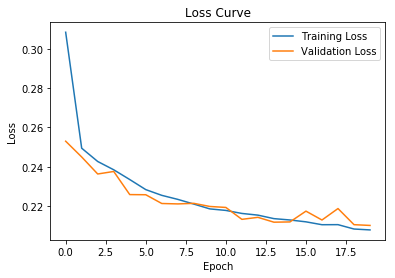

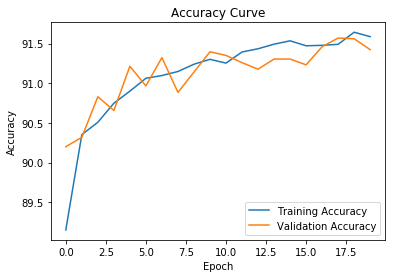

Test: [0/110]	Time 0.054 (0.054)	Loss 0.1884 (0.1884)	Accuracy 93.000 (93.000)
Test: [50/110]	Time 0.008 (0.011)	Loss 0.3611 (0.2133)	Accuracy 87.000 (91.784)
Test: [100/110]	Time 0.009 (0.010)	Loss 0.4137 (0.2158)	Accuracy 82.000 (91.604)


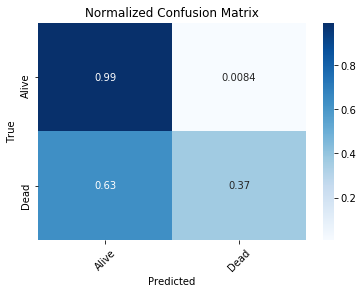

In [52]:
# train model


model = MyVariableRNN(num_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(PATH_OUTPUT, "MyVariableRNN_chart48.pth"))

best_model = torch.load(os.path.join(PATH_OUTPUT, "MyVariableRNN_chart48.pth"))
# TODO: For your report, try to make plots similar to those in the previous task.
# TODO: You may use the validation set in case you cannot use the test set.

plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
valid_loss, valid_accuracy, valid_results = evaluate(best_model, device, valid_loader, criterion)
class_names = ['Alive', 'Dead']
plot_confusion_matrix(valid_results, class_names)

In [53]:
# prediction on test dataset
def predict_mortality(model, device, data_loader):
	model.eval()
	# TODO: Evaluate the data (from data_loader) using model,
	# TODO: return a List of probabilities
	# probas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
	probas = []
	    
	for i, (inputs, targets) in enumerate(data_loader):
		outputs = model(inputs)
		probas.extend(torch.sigmoid(outputs)[:, 1])
  
	return probas

test_prob = predict_mortality(best_model, device, test_loader)

In [54]:
preds = [i.item() for i in test_prob]

In [55]:
import numpy as np
from sklearn import metrics
y = test_label
fpr, tpr, thresholds = metrics.roc_curve(y, preds, pos_label=1)
metrics.auc(fpr, tpr)

0.9060003992414848

In [56]:
metrics.roc_auc_score(y, preds)

0.9060003992414848

In [ ]:
metrics.accu(y, preds)